### Imports

In [29]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sympy import Matrix, Rational

### p-adic Valuation Function

In [30]:
def v_p(x, p):
    """
    Calculates p-adic valuation of an integer x.
    """
    if x == 0:
        return float('inf')

    v = 0
    x = abs(x)
    while x % p == 0:
        x //= p
        v += 1
    return v

### p-adic Norm Function

In [31]:
def norm(x, p):
    """
    Calculates p-adic norm of a Fraction/Rational x using exact arithmetic.
    Returns a SymPy Rational.
    """
    # Handle SymPy Rational or Python Fraction inputs
    if hasattr(x, 'p'): # SymPy Rational
        a, b = x.p, x.q
    elif hasattr(x, 'numerator'): # Python Fraction
        a, b = x.numerator, x.denominator
    else: # Integer or Float (cast to Rational first to be safe)
        x_rat = Rational(x)
        a, b = x_rat.p, x_rat.q

    if a == 0:
        return Rational(0)

    # val(a/b) = val(a) - val(b)
    # norm(x) = p ^ (-val(x)) = p ^ (val(b) - val(a))
    exponent = v_p(b, p) - v_p(a, p)

    # Return exact Rational
    return Rational(p) ** exponent

### Ball Generation Function

In [32]:
def Ball(x0, k, p, n, digits=10, dim=2):
    """
    Generate n random points inside the p-adic ball B(x0, p^-k).
    """
    samples = []
    powers = [p**i for i in range(digits)]

    for _ in range(n):
        vec = []
        for d in range(dim):
            dig = [random.randint(0, p-1) for _ in range(digits)]
            u = sum(di * pw for di, pw in zip(dig, powers))
            x = x0[d] + (p**k) * u
            vec.append(x)
        samples.append(vec)

    return np.array(samples)

### Data Visualization Function

In [33]:
def draw_data(X, y, title="p-adic Data"):
    """
    Plots the actual dataset X used for regression.
    """
    plt.figure(figsize=(7, 7))

    # Separate classes based on y label
    X0 = X[y == 0]
    X1 = X[y == 1]

    plt.scatter(X0[:, 0], X0[:, 1], s=25, alpha=0.7, label='Class 0', c='blue')
    plt.scatter(X1[:, 0], X1[:, 1], s=25, alpha=0.7, label='Class 1', c='red')

    plt.title(title)
    plt.xlabel("Coordinate 1")
    plt.ylabel("Coordinate 2")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()

### Loss Function

In [34]:
def loss(X_full, y_full, V, rows_total, p):
    """
    Calculates total p-adic loss using Exact Arithmetic.
    """
    total_loss = Rational(0)

    # Extract weights and bias from V vector
    # V has shape (dim + 1, 1)
    # Weights are V[0]...V[dim-1], Bias is V[dim]
    dim = X_full.shape[1]
    weights = V[:dim, 0]
    bias = V[dim, 0]

    for i in range(rows_total):
        x_row = X_full[i, :]

        # dot product: w * x
        prediction = Rational(0)
        for j in range(dim):
            prediction += weights[j] * Rational(x_row[j])

        prediction += bias

        # Residual
        y_true = Rational(y_full[i])
        delta = prediction - y_true

        # Add p-adic norm
        total_loss += norm(delta, p)

    return total_loss

### Linear Regression Function

In [35]:
def Linear_Regression_fraction(X, y, dim, p):
    best_bias = float('inf')
    best_V = None

    X = np.array(X)
    y = np.array(y)

    total_points = X.shape[0]
    # We need dim weights + 1 bias
    points_needed = dim + 1

    print(f"Searching {math.comb(total_points, points_needed)} combinations...")

    for idx in combinations(range(total_points), points_needed):
        idx_list = list(idx)
        X_subset = X[idx_list, :]
        y_subset = y[idx_list]

        # Build augmented matrix [X | 1]
        # Using Rational for exactness
        aug_data = []
        for i in range(points_needed):
            row = [Rational(x_val) for x_val in X_subset[i]]
            row.append(Rational(1))
            aug_data.append(row)

        A = Matrix(aug_data)
        b = Matrix([Rational(val) for val in y_subset])

        # Check determinant to avoid singular matrices early (optional optimization)
        if A.det() == 0:
            continue

        try:
            V_candidate = A.gauss_jordan_solve(b)[0]
            current_bias = loss(X, y, V_candidate, total_points, p)

            if current_bias < best_bias:
                best_bias = current_bias
                best_V = V_candidate
                # print(f"New best loss: {float(best_bias)}")

        except Exception:
            continue

    return best_V, best_bias

### Main Execution: Data Generation, Visualization, and Regression

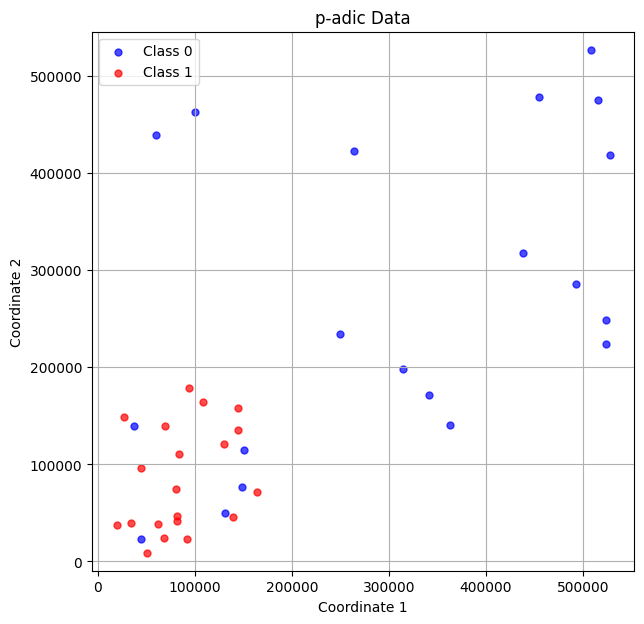

In [36]:
# Parameters
p = 3
n_samples = 20
dim = 2

# Define Centers
center1 = [10, 10]
center2 = [1000, 3000]

k1 = 2
k2 = 1

# Generate Data
X1 = Ball(x0=center1, k=k1, p=p, n=n_samples, dim=dim)
y1 = np.zeros(n_samples)

X2 = Ball(x0=center2, k=k2, p=p, n=n_samples, dim=dim)
y2 = np.ones(n_samples)

X = np.vstack((X1, X2))
y = np.hstack((y1, y2))

# 1. Visualize the ACTUAL data
draw_data(X, y)

In [37]:
# 2. Run Regression
best_V, min_loss = Linear_Regression_fraction(X, y, dim, p)

print("\n--- Results ---")
print("Best Weights (SymPy Matrix):")
print(best_V)
print(f"Minimum p-adic Loss (Exact): {min_loss}")
print(f"Minimum p-adic Loss (Float): {float(min_loss)}")

Searching 9880 combinations...

--- Results ---
Best Weights (SymPy Matrix):
Matrix([[-7363/80791388], [-3020/20197847], [393122910/20197847]])
Minimum p-adic Loss (Exact): 12187/2187
Minimum p-adic Loss (Float): 5.572473708276178


### Evaluate Accuracy on a Test Set

In [39]:
if best_V is not None:
    # Generate Test Data (using the same centers and k values as training)
    n_test_samples = 20 # Number of test samples per class

    X1_test = Ball(x0=center1, k=k1, p=p, n=n_test_samples, dim=dim)
    y1_test = np.zeros(n_test_samples)

    X2_test = Ball(x0=center2, k=k2, p=p, n=n_test_samples, dim=dim)
    y2_test = np.ones(n_test_samples)

    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))

    print(f"\n--- Evaluating Accuracy on {len(X_test)} Test Points ---")

    # Extract weights and bias from best_V
    weights = best_V[:dim, 0]
    bias = best_V[dim, 0]

    correct_predictions = 0
    for i in range(len(X_test)):
        x_row = X_test[i, :]
        y_true = y_test[i]

        # Calculate prediction: w * x + b
        prediction = Rational(0)
        for j in range(dim):
            prediction += weights[j] * Rational(x_row[j])
        prediction += bias

        # Determine predicted class based on p-adic norm closeness
        # Which class (0 or 1) is the prediction p-adically closer to?
        norm_to_0 = norm(prediction, p)
        norm_to_1 = norm(prediction - 1, p)

        predicted_class = None
        if norm_to_0 < norm_to_1:
            predicted_class = 0
        elif norm_to_1 < norm_to_0:
            predicted_class = 1
        # If norms are equal, it's ambiguous. For simplicity, we can skip or default.
        # Given it's rational arithmetic, equality is possible but less likely if distinct.

        if predicted_class is not None and predicted_class == y_true:
            correct_predictions += 1

    accuracy = correct_predictions / len(X_test)
    print(f"Correct Predictions: {correct_predictions}/{len(X_test)}")
    print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")
else:
    print("\nCannot evaluate accuracy: No best regression line found.")


--- Evaluating Accuracy on 40 Test Points ---
Correct Predictions: 40/40
Accuracy on Test Set: 100.00%
